# Ship or Iceberg
https://www.kaggle.com/c/statoil-iceberg-classifier-challenge

### Next steps for this model
* Work out how to get *probabilities* rather than just numbers at the end
* submit!


### Next steps in general
* Read some papers about NN to work out how they work
    * http://www.cs.toronto.edu/~hinton/absps/momentum.pdf
    * http://www.exegetic.biz/blog/2015/12/making-sense-logarithmic-loss/
    

# Initialisation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [62]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import sklearn.preprocessing
import sklearn.model_selection

import matplotlib.pyplot as plt
from tqdm import tqdm

# Data

Load and preprocess data

In [3]:
datadir = "/home/christopher/Data/data/ml/ship-or-iceberg/"

with open(datadir + "train.json") as f:
    raw_train = pd.read_json(f).set_index("id")
    
with open(datadir + "test.json") as f:
    raw_test = pd.read_json(f).set_index("id")
raw_train.head()

,band_1,band_2,inc_angle,is_iceberg
id,,,,
dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [136]:
band1 = np.array([np.array([i]) for i in raw_train["band_1"]], dtype=np.float32)
band2 = np.array([np.array([i]) for i in raw_train["band_2"]], dtype=np.float32)
train_data_all = np.concatenate((band1, band2), axis=1)

band1 = np.array([np.array([i]) for i in raw_test["band_1"]], dtype=np.float32)
band2 = np.array([np.array([i]) for i in raw_test["band_2"]], dtype=np.float32)
test_data_all = np.concatenate((band1, band2), axis=1)
del(band1, band2)

In [137]:
train_data_all = train_data_all.reshape(len(train_data_all), -1)
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(train_data_all)
train_data_all = scaler.transform(train_data_all)
train_data_all = train_data_all.reshape(len(train_data_all), 2, 75, 75)

test_data_all = test_data_all.reshape(len(test_data_all), -1)
test_data_all = scaler.transform(test_data_all)
test_data_all = test_data_all.reshape(len(test_data_all), 2, 75, 75)

In [145]:
train_labels_all = np.zeros((len(raw_train), 2), dtype=np.float32)
for i, is_iceberg in enumerate(raw_train["is_iceberg"]):
    train_labels_all[i][is_iceberg] = 1

In [146]:
train_data, valid_data, train_labels, valid_labels = sklearn.model_selection.train_test_split(train_data_all, train_labels_all, test_size=204)

train_data = autograd.Variable(torch.from_numpy(train_data))
train_labels = autograd.Variable(torch.from_numpy(train_labels))

valid_data = autograd.Variable(torch.from_numpy(valid_data))
valid_label = autograd.Variable(torch.from_numpy(valid_labels))

test_data = autograd.Variable(torch.from_numpy(test_data_all))

# Data summary

In [147]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)
print(np.sum(train_labels.data.numpy()[:,0])/len(train_labels)) # Classes are almost equally represented

torch.Size([1400, 2, 75, 75])
torch.Size([204, 2, 75, 75])
torch.Size([8424, 2, 75, 75])
0.535


# Build Neural Network and Train

In [148]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(2, 3, 4) # in_chan, out_chan, kernel_size
        self.conv2 = nn.Conv2d(3, 6, 5)
        self.lin1 = nn.Linear(6 * 10 * 10, 200) # in_feat, out_feat
        self.lin2 = nn.Linear(200, 50)
        self.lin3 = nn.Linear(50, 2)
    
    def forward(self, x):
        # 2x75x75 -> 3x72x72 -> 3x24x24 -> 6x20x20 -> 6x10x10 -> 3*24*24 -> 200 -> 50 -> 2
        x = F.max_pool2d(self.conv1(x), 3)
        x = F.max_pool2d(self.conv2(x), 2)
        x = x.view(-1, 6*10*10)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.softmin(self.lin3(x), 1)
        return x
    
net = Net().cuda()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)
tracked_loss = []

0.49148811373606804: 100%|██████████| 600/600 [02:33<00:00,  3.92it/s]


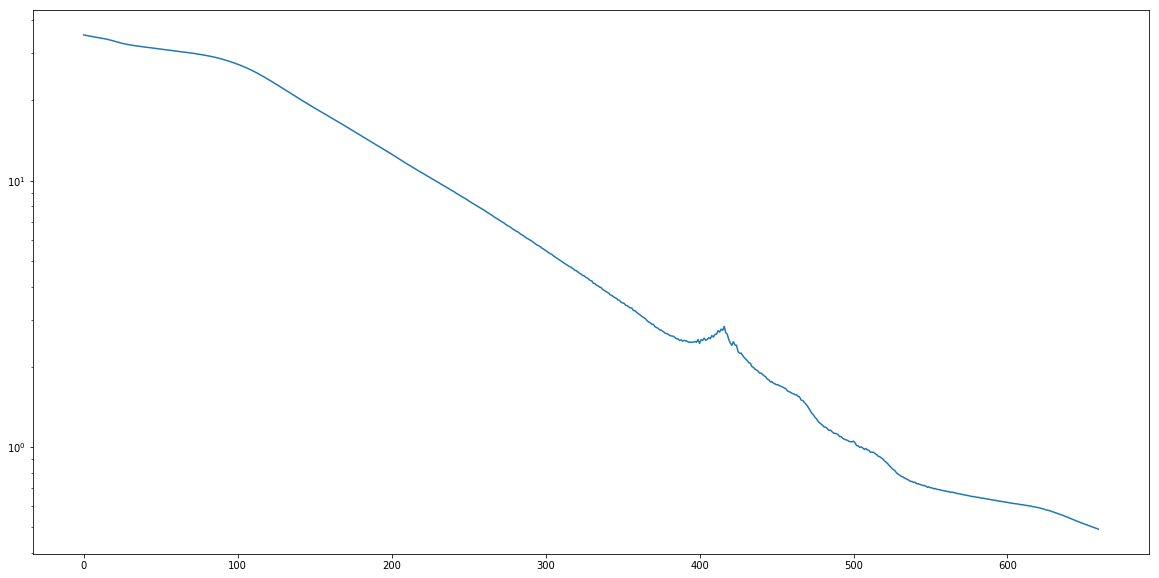

In [164]:
t = tqdm(range(600)) # 600 appears to be optimal at present
for epoch in t:
    batch_size = 10
    running_loss = 0.0
    for start in np.arange(0, len(train_data) - batch_size, batch_size):
        batch_input = train_data[start:start+batch_size].cuda()
        batch_labels = train_labels[start:start+batch_size].cuda()
        optimizer.zero_grad()
    
        batch_output = net(batch_input)
        batch_loss = F.mse_loss(batch_output, batch_labels)
        batch_loss.backward()
        optimizer.step()
        running_loss += batch_loss.data[0]
    t.set_description(str(running_loss))
    tracked_loss.append(running_loss)

fig, ax = plt.subplots(figsize=(20, 10))
ax.set(yscale = "log")
ax.plot(tracked_loss)

# Validation

In [173]:
out = net(valid_data.cuda()).data.cpu().numpy()
exp = np.argmax(valid_label.data.numpy(), axis=1)
res = np.argmax(out, axis=1)

print("How do we perform on boats, icebergs, overall")
print(np.sum(res[exp == 0] == 0) / np.count_nonzero(exp == 0))
print(np.sum(res[exp == 1] == 1) / np.count_nonzero(exp == 1))
print(np.sum(res == exp) / len(res))
print("This is much better than random!")

cls = autograd.Variable(torch.from_numpy(exp))

for i in range(len(out)):
    if out[i][1] > 0.99:
        out[i][1] = 0.99
        out[i][0] = 0.01
    elif out[i][1] < 0.01:
        out[i][1] = 0.01
        out[i][0] = 0.99
F.nll_loss(autograd.Variable(torch.from_numpy(out)), cls)

How do we perform on boats, icebergs, overall
0.882352941176
0.823529411765
0.852941176471
This is much better than random!


Variable containing:
-0.8357
[torch.FloatTensor of size 1]

# Test

In [177]:
out = net(test_data.cuda())

In [178]:
out = out.data.cpu().numpy()

In [179]:
out[:10]

array([[  9.88311827e-01,   1.16881272e-02],
       [  9.27672446e-01,   7.23275989e-02],
       [  6.54809922e-03,   9.93451953e-01],
       [  5.96105761e-04,   9.99403954e-01],
       [  3.39964870e-04,   9.99660015e-01],
       [  9.84457195e-01,   1.55428154e-02],
       [  9.99933958e-01,   6.60906444e-05],
       [  6.93034039e-08,   9.99999881e-01],
       [  9.99998450e-01,   1.56239457e-06],
       [  1.00000000e+00,   8.31108848e-10]], dtype=float32)

In [180]:
# Index 0 is greater - no iceberg
# Index 1 is greater - iceberg
x = 0.2
f = open("results.txt", "w")
f.write("id,is_iceberg\n")
for i in range(len(out)):
    res = out[i][1]
    if res > 0.99:
        res = 0.99
    elif res < 0.01:
        res = 0.01
    f.write("{},{}\n".format(raw_test.index[i], res))
f.close()